<a href="https://colab.research.google.com/github/ManideepLadi/cs6910_assignment3/blob/manideep/RNN_WithoutAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dakshina Dataset from google


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from tensorflow.keras.utils import plot_model
from copy import copy
from math import log
import math


In [ ]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

In [ ]:
!tar -xvf '/content/dakshina_dataset_v1.0.tar'

Preprocess data

In [19]:
train_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
validation_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
test_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

Preprocessing of Training Data

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
inputdata=[]
with open(train_filename, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    inputdata.append(line)
random.shuffle(inputdata)
for line in inputdata:
    target_text,input_text, attestation = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of unique input tokens: 26
Number of unique output tokens: 65
Max sequence length for inputs: 20
Max sequence length for outputs: 21


Preprocessin of Validation Data

In [6]:
# Vectorize the data.
validation_input_texts = []
validation_target_texts = []

with open(validation_filename, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    validation_target_text,validation_input_text, attestation = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    validation_target_text = "\t" + validation_target_text + "\n"
    validation_input_texts.append(validation_input_text)
    validation_target_texts.append(validation_target_text)
    for char in validation_input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in validation_target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
validation_num_encoder_tokens = len(input_characters)
validation_num_decoder_tokens = len(target_characters)
validation_max_encoder_seq_length = max([len(txt) for txt in validation_input_texts])
validation_max_decoder_seq_length = max([len(txt) for txt in validation_target_texts])

print("Number of validation samples:", len(validation_input_texts))
print("Number of unique input tokens:", validation_num_encoder_tokens)
print("Number of unique output tokens:", validation_num_decoder_tokens)
print("validation Max sequence length for inputs:", validation_max_encoder_seq_length)
print("validation Max sequence length for outputs:", validation_max_decoder_seq_length)

Number of validation samples: 4358
Number of unique input tokens: 26
Number of unique output tokens: 65
validation Max sequence length for inputs: 18
validation Max sequence length for outputs: 16


Preprocessing of Test Data

In [21]:
# Vectorize the data.
test_input_texts = []
test_target_texts = []

with open(test_filename, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    test_target_text,test_input_text, attestation = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_target_text = "\t" + test_target_text + "\n"
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text)

test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])

print("Number of validation samples:", len(test_input_texts))
print("Test Max sequence length for inputs:", test_max_encoder_seq_length)
print("Test Max sequence length for outputs:", test_max_decoder_seq_length)

Number of validation samples: 4502
Test Max sequence length for inputs: 16
Test Max sequence length for outputs: 17


In [22]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
validation_encoder_input_data=np.zeros(
    (len(validation_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
test_encoder_input_data=np.zeros(
    (len(test_input_texts), test_max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
validation_decoder_input_data =np.zeros(
    (len(validation_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
validation_decoder_target_data = np.zeros(
    (len(validation_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
# for validation data
for i, (validation_input_text, validation_target_text) in enumerate(zip(validation_input_texts, validation_target_texts)):
    for t, char in enumerate(validation_input_text):
        validation_encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(validation_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        validation_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            validation_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# for test data
for i, (test_input_text, test_target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, input_token_index[char]] = 1.0

In [24]:
test_target_texts[100]

'\tअनुकूलता\n'

In [8]:
class Utility:
  def beam_search_decoder(self,data, k):
    decodedSequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
      all_candidates = list()
      # expand each current candidate
      for i in range(len(decodedSequences)):
        seq, score = decodedSequences[i]
        for j in range(len(row)):
          candidate = [seq + [j], score - log(row[j])]
          all_candidates.append(candidate)
      # order all candidates by score
      ordered = sorted(all_candidates, key=lambda tup:tup[1])
      # select k best
      decodedSequences = ordered[:k]
    return decodedSequences
  
  def decode_translate(self,seq):
    decoded_sentence = [] 
    for x in seq:
      sampled_char = reverse_target_char_index[x]
      decoded_sentence.append(sampled_char)
    return "".join(decoded_sentence)
  
  def decode_sequence_using_inference(self,input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = []  
    while not stop_condition:
        to_split = decoder_model.predict([target_seq] + states_value)

        output_tokens, states_value = to_split[0], to_split[1:]

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

    return "".join(decoded_sentence)




In [9]:
class WordAccuracyCallback(keras.callbacks.Callback):
  def __init__(self,beam_size):
    self.beam_size=beam_size
  def on_epoch_end(self, epoch, logs=None):
    yPred=self.model.predict([validation_encoder_input_data,validation_decoder_input_data])
    count=0
    U=Utility()
    k=self.beam_size
    for i in range(yPred.shape[0]):
      predictedSequences=U.beam_search_decoder(yPred[i],k)
      for j in range(k):
        if "\t"+U.decode_translate(predictedSequences[j][0][:len(validation_target_texts[i])-1])==validation_target_texts[i]:
          count=count+1
          break
    factor = 10.0 ** 4
    logs["WordAccuracy"]=math.trunc((count/yPred.shape[0])*factor)/factor
    print("- wordAccuracy:",logs["WordAccuracy"])

In [14]:
class RNN_Model:

  def __init__(self,no_of_encoder_layers,no_of_decoder_layers,latent_dimension,dropout,recurrent_dropout,cell_type,beam_size):

    self.no_of_encoder_layers = no_of_encoder_layers
    self.no_of_decoder_layers = no_of_decoder_layers
    self.latent_dimension = latent_dimension
    self.dropout = dropout
    self.recurrent_dropout=recurrent_dropout
    self.cell_type=cell_type
    self.model = None
    self.encoder_inputs= None
    self.encoder_states = None
    self.decoder_inputs = None
    self.output_layers = []
    self.decoder_dense = None
    self.beam_size = beam_size


  def printModelParameters(self):
    print(self.no_of_encoder_layers)
    print(self.no_of_decoder_layers)
    print(self.latent_dimension)
    print(self.dropout)
    print(self.model.summary())

  def BUILD_MODEL(self,num_encoder_tokens,num_decoder_tokens):
    self.encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

    outputs = self.encoder_inputs
    self.encoder_states = []
    for j in range(self.no_of_encoder_layers)[::-1]:
      if self.cell_type == "LSTM":
        outputs, h , c = keras.layers.LSTM(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [h,c]
      elif self.cell_type == "GRU" :
        outputs, h = keras.layers.GRU(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [h]
      elif self.cell_type == "RNN" :
        outputs, h = keras.layers.SimpleRNN(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [h]
    
    self.decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
    outputs = self.decoder_inputs
    for j in range(self.no_of_decoder_layers):
        if self.cell_type == "LSTM":
          self.output_layers.append(
              keras.layers.LSTM(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh, dc = self.output_layers[-1](outputs, initial_state=self.encoder_states[2*j:2*(j+1)])
        elif self.cell_type == "GRU" : 
          self.output_layers.append(
              keras.layers.GRU(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh = self.output_layers[-1](outputs, initial_state=self.encoder_states[j:j+1])
        elif self.cell_type == "RNN" : 
          self.output_layers.append(
              keras.layers.SimpleRNN(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh = self.output_layers[-1](outputs, initial_state=self.encoder_states[j:j+1])

 
    self.decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = self.decoder_dense(outputs)
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    self.model = keras.Model([self.encoder_inputs, self.decoder_inputs], decoder_outputs)
    self.model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy']) 
    return 


  #Fit model using the train datagenerator and returns fitted model..
  def FIT_RNN(self , encoder_input_data,decoder_input_data ,decoder_target_data,epochs ,batch_size,validation_encoder_input_data,validation_decoder_input_data,validation_decoder_target_data):
    self.model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks = [WordAccuracyCallback(self.beam_size),WandbCallback(monitor='WordAccuracy',
                                                    save_model = True)],verbose=1)
        # callbacks = [WandbCallback(monitor='val_accuracy',
        #                                             save_model = True)],verbose=1)
    return
  def load_model(self):
    encoder_model = keras.Model(self.encoder_inputs, self.encoder_states)
    d_outputs = self.decoder_inputs
    decoder_states_inputs = []
    decoder_states = []
    for j in range(self.no_of_decoder_layers):
        if self.cell_type =="LSTM":
          current_state_inputs = [keras.Input(shape=(self.latent_dimension*(2**(j)),)) for _ in range(2)]
        else :
          current_state_inputs = [keras.Input(shape=(self.latent_dimension*(2**(j)),))]

        temp = self.output_layers[j](d_outputs, initial_state=current_state_inputs)

        d_outputs, cur_states = temp[0], temp[1:]

        decoder_states += cur_states
        decoder_states_inputs += current_state_inputs

    decoder_outputs = self.decoder_dense(d_outputs)
    decoder_model = keras.Model(
        [self.decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    return encoder_model,decoder_model


In [11]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8MB 6.6MB/s 
     |████████████████████████████████| 174kB 21.4MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 133kB 23.0MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
import wandb
from wandb.keras import WandbCallback

In [13]:
sweep_config = {
  'name': 'RNN',
  'method': 'bayes',
  'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  'parameters': {
        'encoder_layers':{
            'values':[1,2,3]
        },
        'decoder_layers':{
            'values':[1,2,3]
        },
        'hidden_layer_size':{
            'values':[64,128,256]
        },
        'cell_type':{
            'values':['GRU', 'LSTM','RNN']
        },
        'dropout':{
            'values':[0.0,0.3]
        },
        'recurrent_dropout':{
            'values':[0.0,0.3]
        },
        'beam_size':{
            'values':[1,3,5]
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='RNN_Assignment', entity='manideepladi')

Create sweep with ID: z9q9axa7
Sweep URL: https://wandb.ai/manideepladi/RNN_Assignment/sweeps/z9q9axa7


In [ ]:
def train():
  run = wandb.init()
  configuration=run.config
  if configuration.encoder_layers >= configuration.decoder_layers:
    rnn = RNN_Model(no_of_encoder_layers=configuration.encoder_layers,no_of_decoder_layers=configuration.decoder_layers,
                    latent_dimension=configuration.hidden_layer_size,dropout=configuration.dropout,recurrent_dropout=configuration.recurrent_dropout,cell_type=configuration.cell_type,beam_size=configuration.beam_size)
    rnn.BUILD_MODEL(num_encoder_tokens,num_decoder_tokens)
    rnn.FIT_RNN( encoder_input_data,decoder_input_data,  decoder_target_data,10,64,
      validation_encoder_input_data , validation_decoder_input_data, validation_decoder_target_data)
sweep_id="kczjjuqs"
wandb.agent(sweep_id=sweep_id, function=train)

Training few best models found using hyperparamater tuning

In [15]:
rnn = RNN_Model(3,3,256,0,0.3,"LSTM",5)
rnn.BUILD_MODEL(num_encoder_tokens,num_decoder_tokens)

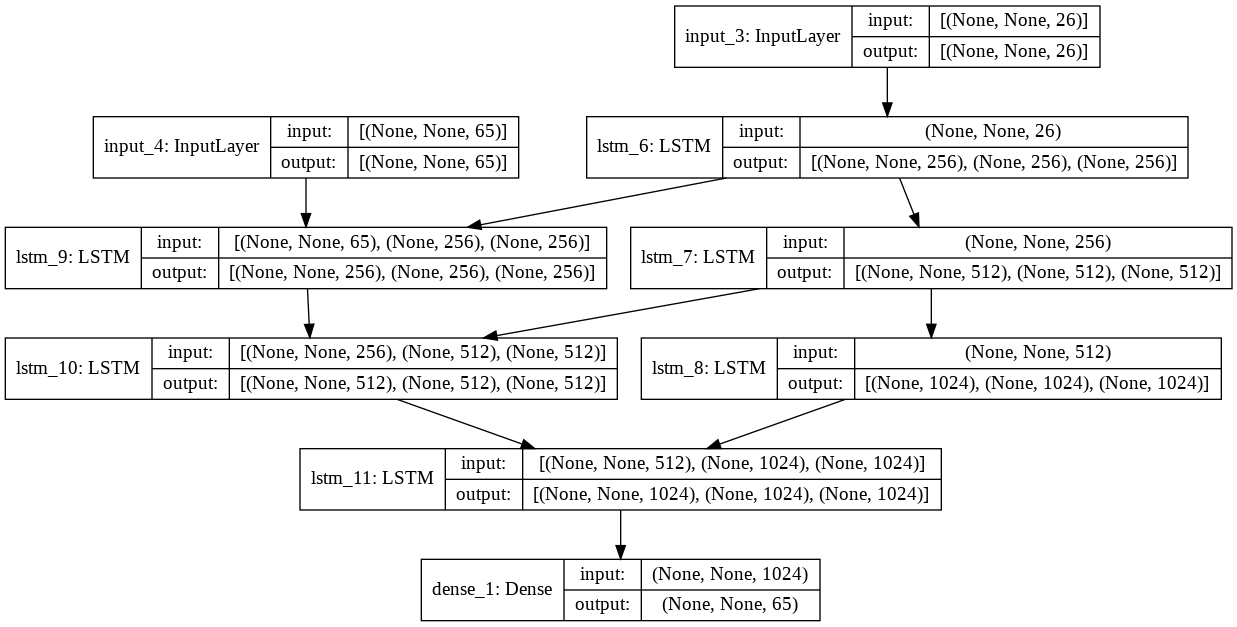

In [16]:
plot_model(rnn.model, show_shapes=True)

In [ ]:
rnn.FIT_RNN( encoder_input_data,decoder_input_data,  decoder_target_data,10,64,
    validation_encoder_input_data,
    validation_decoder_input_data,validation_decoder_target_data)

In [27]:
  def get_predictions(ip_data,op_text,encoder_moder,decoder_model):
    n=len(ip_data)
    predictions = []
    num_correct = 0
    U=Utility()
    for i in range(n):
      input_seq = ip_data[i:i+1]
      decoded_seq = U.decode_sequence_using_inference(input_seq,encoder_model,decoder_model)
      if decoded_seq[-1]=='\n':
        decoded_seq = decoded_seq[:-1]

      predictions+=[decoded_seq]
      #excluding the '\t and \n'
      true_word = op_text[i][1:-1]
      #getting word level accuracy...
      num_correct+=(decoded_seq == true_word)

    acc = num_correct/n
    return (acc,predictions)

In [28]:
encoder_model,decoder_model= rnn.load_model()
test_wordAccuracy,predictions=get_predictions(test_encoder_input_data,test_target_texts,encoder_model,decoder_model)
print(test_wordAccuracy)

0.3494002665482008


In [30]:
with open('prediction_vanilla.txt','w') as f:
  f.write('predicted_word'+'\t'+'true_word\n')
  for i in range(len(predictions)):
    f.write(predictions[i]+'\t'+test_target_texts[i])

Best model from hyperparameter tuning

In [ ]:
rnn2 = RNN_Model(3,3,256,0,0,"GRU",5)
rnn2.BUILD_MODEL(num_encoder_tokens,num_decoder_tokens)
rnn2.FIT_RNN( encoder_input_data,decoder_input_data,  decoder_target_data,10,64,
    validation_encoder_input_data,
    validation_decoder_input_data,validation_decoder_target_data)

In [32]:
encoder_model,decoder_model= rnn2.load_model()
test_wordAccuracy,predictions=get_predictions(test_encoder_input_data,test_target_texts,encoder_model,decoder_model)
print(test_wordAccuracy)

0.35961794757885385


In [34]:
with open('prediction_vanilla2.txt','w') as f:
  f.write('predicted_word'+'\t'+'true_word\n')
  for i in range(len(predictions)):
    f.write(predictions[i]+'\t'+test_target_texts[i])

In [138]:
long_index_nos= [ 843,4069,3750,535,121]
short_index_nos = [1166,1032,3151,1063,2515]

In [139]:
  def get_prediction_word(index_nos,encoder_moder,decoder_model):
    predictions=[]
    U=Utility()
    for i in range(len(index_nos)):
      index=index_nos[i]
      input_seq = test_encoder_input_data[index:index+1]
      decoded_seq = U.decode_sequence_using_inference(input_seq,encoder_model,decoder_model)
      if decoded_seq[-1]=='\n':
        decoded_seq = decoded_seq[:-1]

      predictions+=[decoded_seq]
    return predictions

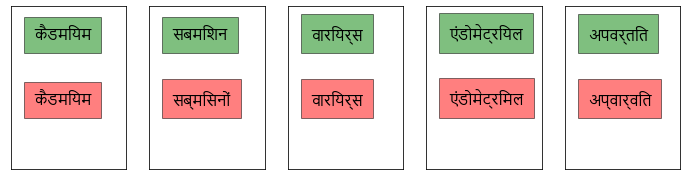

In [159]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = '/content/Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(long_index_nos),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(long_index_nos)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,long_index_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target_texts[long_index_nos[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')

plt.show()

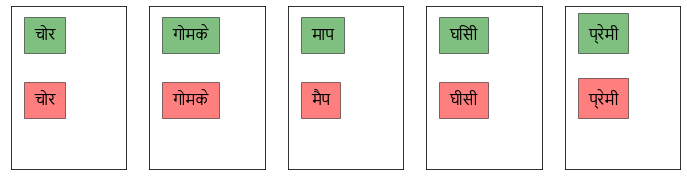

In [162]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = '/content/Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(short_index_nos),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(short_index_nos)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,short_index_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target_texts[short_index_nos[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')

plt.show()